## Import Libraries

In [ ]:
!pip install datasets

In [ ]:
!pip install laserembeddings
!python -m laserembeddings download-models

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import time
from datasets import load_dataset

import re
import string

from transformers import AutoTokenizer, AutoModel
from laserembeddings import Laser
import torch
from torch.utils.data import DataLoader
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from lightgbm import LGBMClassifier

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report,\
                                                  confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train = pd.read_csv("./drive/MyDrive/NLP Task/df_train.csv")
df_val = pd.read_csv("./drive/MyDrive/NLP Task/df_val.csv")

## Load Dataset

In [ ]:
data_path = "MonoHime/ru_sentiment_dataset"
dataset = load_dataset(data_path, revision="main")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [ ]:
df_train, df_val = dataset["train"], dataset["validation"]

In [ ]:
# Удалим ненужную колонку с индексами сразу, чтобы они шли по порядку
assert len(np.unique(df_train["Unnamed: 0"])) == len(df_train)
assert len(np.unique(df_val["Unnamed: 0"])) == len(df_val)

df_train = df_train.remove_columns("Unnamed: 0")
df_val = df_val.remove_columns("Unnamed: 0")

In [ ]:
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)

In [ ]:
id2label = {0: "neutral", 1: "positive", 2: "negative"}
label2id = {"neutral": 0, "positive": 1, "negative": 2}

In [ ]:
del dataset

## Explore Data Analysis

Всегда вначале стоит просто взглянуть на данные, насемплировав несколько примеров. Эти и некоторые другие очевидные первичные действия я оставлю за кадром.

#### Classes balance

In [ ]:
classes_train = Counter(df_train["sentiment"])
classes_val = Counter(df_val["sentiment"])

classes = pd.DataFrame({"class": list(classes_train.keys())
                                + list(classes_val.keys()),
                        "cnt": list(classes_train.values())
                               + list(classes_val.values()),
                        "part": ["Train"]*len(classes_train)
                                + ["Val"]*len(classes_val),
                        })

In [ ]:
fig = px.bar(classes, x="class", y="cnt", color="class", facet_col="part")
fig.show()

Видим, что дисбаланса классов нет.

**Замечание:** Если бы дисбаланс классов был, то методы борьбы с этим стандартные:


*   **Понижение.** Понижать кол-во наблюдений преобладающих классов (но обычно никто не жертвует данными за исключением редких случаев, когда их в избытке)
*   **Генерация искуственно похожих.** Можно сгенерировать искуственные данные недостающим классам (например, SMOTE для табличных данных) или обратиться за помощью к генеративным моделям, умеющим суммаризировать или перефразировать текст.
* **Аугментация.**Тут мы не генерируем искуственные данные, а трансформируем имеющиеся, добавляя их в общий датасет. В случае с картинками это могут быть более понятные преобразования (обрезать, повернуть картинку и тд.), с текстами же всё интереснее. Обычно могут:
  * менять слова местами внутри одного предложения (не лучший способ для моделей, обращающих внимание на контекст)
  * допустить орфографическую ошибку
  * заменять слова синонимами



#### Text preprocessing

Для дальнейшей работы над первичным анализом текста нам понадобится слегка предобработать текст. Выполним некоторые стандартные преобразования, а именно:
* Избавление от цифр
* Избавление от знаков пунктуации
* Приведение текста к нижнему регистру
* Избавление от стоп-слов
* Нормализация слов: стемминг (можно попробовать лемматизацию)
* Избавление от текстов ставшими пустыми

In [ ]:
snowball = SnowballStemmer('russian')
def prepare_text(text: str) -> str:
  text = re.sub('[0-9]', '', text)

  text = text.lower()

  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)

  stop_words = stopwords.words('russian')
  text = " ".join([snowball.stem(word) for word in text.split()
                  if word not in stop_words])

  text = text.strip()

  text = text if text != '' else np.nan
  return text


def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
  df["text_prep"] = df["text"].apply(lambda text: prepare_text(text))
  df = df[~df["text_prep"].isna()]
  df = df.reset_index(drop=True)
  return df

In [ ]:
%%time

# text = df_train["text"][54508] # Пример с nan (пока датафрейм не преобразован)
text = df_train["text"][3]
print(f"Before: {text}")
print(f"After: {prepare_text(text)}")

Before: ). Отсутствуют нормативы, Госты и прочее, что позволило бы отличить  хорошие правильные  наркотики от  плохих неправильных . У алкоголя и табака они вырабатывались веками. Кто их будет разрабатывать? Онищенко?)) А значит отличить  хорошие  наркотики от  не хороших  будет не просто, химия не стоит на месте, и генная инженерия тоже, постоянно будут вбрасываться всякие  улучшенные  формы, оборот которых придется контролировать, и опять-таки без репрессивного аппарата не обойтись.5). Отсутствует культура потребления у нашего народа, как например с алкоголем. Есть негласное общественное мнение, традиции, что вот так можно, а так нельзя. Скажем, по праздникам выпивать приличному человеку можно, а вот с утра уже как-то нельзя) Согласитесь, большинство выпивающих ими руководствуется, и это им не позволяет скатываться в алкоголизм. Хотя, конечно, бывает, что кому-то и помогает)6). Аргумент, что все равно все курят, бухают, пьют кофе, а почему нельзя еще и обкуриваться - это вообще не ар

In [ ]:
%%time
df_train = prepare_df(df_train)

In [ ]:
%%time
df_val = prepare_df(df_val)

#### Word Cloud

Посмотрим на часто встречающиеся слова в группе каждой тематики. Я предпочитаю это делать с помощью облака слов, хотя не стоит забывать и о других методах, отражающих частоту токенов.

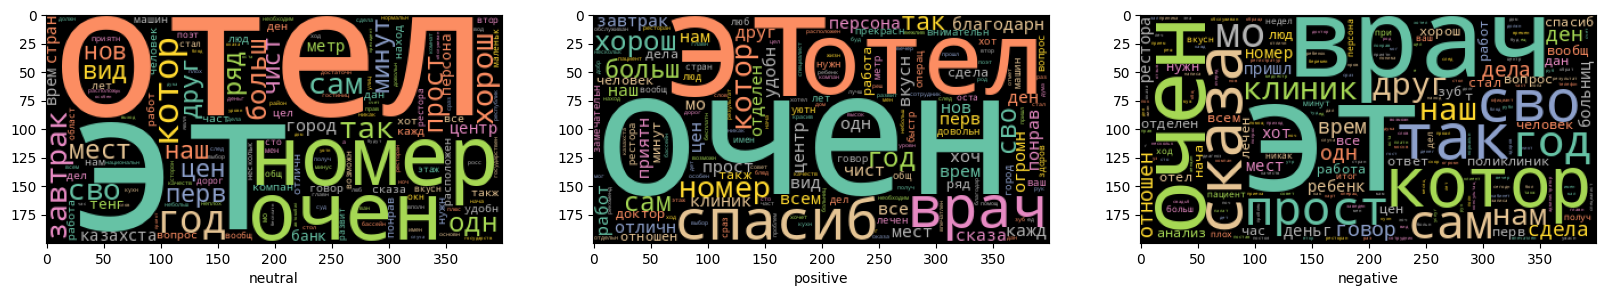

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i, label in enumerate(label2id):
    target = label2id[label]
    all_texts = " ".join(df_train[df_train.sentiment == target]["text_prep"]\
                         .sample(frac=0.5))

    wordCloud = WordCloud(random_state=42, colormap='Set2',
                          collocations=False).generate(all_texts)
    ax[i].imshow(wordCloud)
    ax[i].set_xlabel(label)

Видно, что в позитивных текстах встречаются слова, которые сами по себе вне контекста носят позитивный характер. Например токены, похожие на "спасибо", "благодарность", "хорошо", "огромное" и "большое" (видимо, по отношению к благодарности), "удобно", "вкусно" и тд.

Занятно, что в негативных же примерах слово "врач" встречается несколько чаще, чем в позитивных. Чаще встречаются глаголы, связанные с говорением ("сказал", "говорит") и, конечно же, ни единого слова связанного с благодарностью.

В нейтральных текстах сложно выделить слова-маркеры, они все зачастую нейтрально окращены. Разве что чаще встречаются токены из положительных примеров, но что-то конкретное сказать сложно.

Далее попробуем избавиться от самых частых слов всего корпуса, думаю, они всё ещё являются малоинформативными. А далее вновь взглянем на облако слов.

In [ ]:
top_n = 20
common = Counter([word for text in df_train["text_prep"]
              for word in text.split()]).most_common(top_n)

common, values = zip(*common)
print(f"{top_n} самых популярных слов: {common}")

20 самых популярных слов: ('эт', 'очен', 'отел', 'номер', 'котор', 'врач', 'год', 'так', 'сам', 'сво', 'хорош', 'спасиб', 'прост', 'больш', 'сказа', 'наш', 'одн', 'мест', 'друг', 'мо')


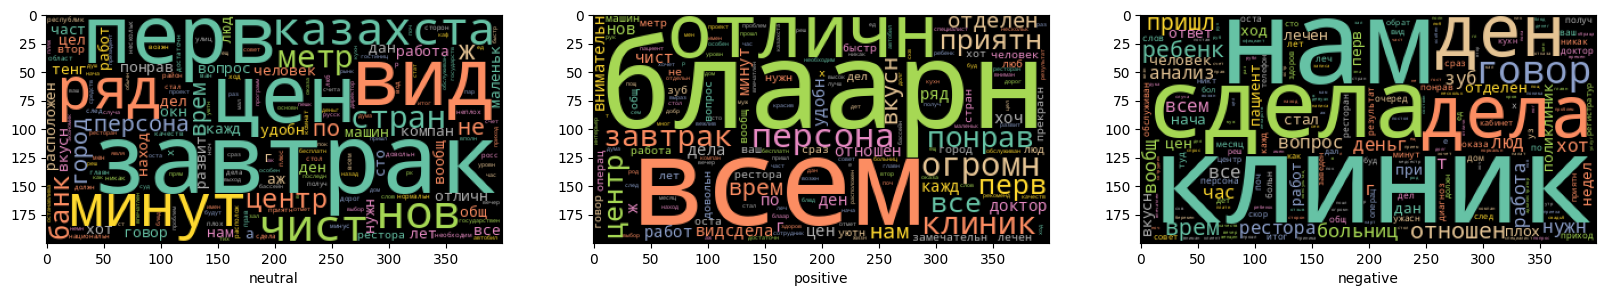

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i, label in enumerate(label2id):
    target = label2id[label]
    all_texts = " ".join(df_train[df_train.sentiment == target]["text_prep"]\
                         .sample(frac=0.5))

    all_texts = re.sub("|".join(common), '', all_texts)

    wordCloud = WordCloud(random_state=42, colormap='Set2',
                          collocations=False).generate(all_texts)
    ax[i].imshow(wordCloud)
    ax[i].set_xlabel(label)

Лучше не стало, результат примерно такой же. Разве что в нейстральных предложениях стал виднеться Казахстан...

#### Text Stats

In [ ]:
df_train.groupby("sentiment").agg({
    "text_prep": [
              ("mean", lambda x: np.mean(x.str.len())),
              ("max", lambda x: np.max(x.str.len())),
              ("min", lambda x: np.min(x.str.len())),
              ("5_quantlile_length", lambda x: np.quantile(x.str.len(), 0.05)),
              ("95_quantlile_length", lambda x: np.quantile(x.str.len(), 0.95)),
              ]
}).rename(lambda x: id2label[x])

text_prep                                                   
                 mean     max min 5_quantlile_length 95_quantlile_length
sentiment                                                               
neutral    618.534071   54318   3               39.0              1755.0
positive   480.283523  275869   2              110.0              1228.0
negative   458.676834   27577   3               49.0              1295.0

Замечаем, что нейтральные тексты в среднем длиннее (результат стат.значим)

## Modeling

Итак, перед нами стоит задача тематического моделирования текстов.

Принято оговариваться, что большинство алгоритмов не воспринмают текст как таковой, намного понятнее и удобнее работать с его векторным представлением. Поэтому план действий следующий:
1. Получить эмбединги текстов
2. Обучить классификатор на получившемся признаковом пространстве (где i-ый признак наблюдения - i-ая координата вектора-эмбединга)

(Ну или воспользоваться готовой большой языковой моделью, которая абсолютно всё сделает за нас)

### Text Embeddings

#### TF-IDF Vectorizer

TF-IDF (на равне с Word2Vec) является христоматийным примером получения эмбеддингов текста. На всякий случай напомним формулу метрики tf-idf:

$
tf\_idf(t, D) =
tf(t, d) * idf(t, D) =
\frac{n_t}{\sum_k n_k} * log(\frac{|D|}{| \{d_i \in D | t \in d_i\}|}) \star
$,

где:
* d - документ, конкретное наблюдение-текст в датасете
* $n_t$ - кол-во раз, которое слово $t$ встретилость в документе d,
* D - весь корпус текста (то есть весь наш датасет)

$\star$ В реализации $idf$ принято добавлять по единичке в числитель и знаменатель логарифма и дополнительно +1



---

Да, в качестве бейзлайна брать Word2Vec или TFIDF векторизацию уместно для небольшого кол-ва текстов небольших размеров. В нашем же случае текстов достаточно много и каждый из них далеко не маленький, поэтому чистым TFIDF воспользоваться мы не сможем (выходит матрица размера (190к х 330к) ).

Поэтому мы ограничим длину выходного вектора размера $n = max\_features$ так, что ненулевыми останутся только $top\_n$ значений. Это удобно, ведь ненулевыми останутся лишь значимые токены!

In [ ]:
vectorizer = TfidfVectorizer(max_features=1024)
embeddings = vectorizer.fit_transform(df_train["text_prep"])
embeddings = embeddings.toarray()

Понизим размерность с помощью PCA и взглянем на данные

In [ ]:
pca = PCA(n_components = 2)
pca_emb = pca.fit_transform(embeddings)

In [ ]:
cnt = 5_000
px.scatter(pd.DataFrame({"x": pca_emb[:cnt, 0],
                          "y": pca_emb[:cnt, 1],
                          "target": df_train.loc[:cnt-1,"sentiment"]}),
           x="x", y="y", color="target")

Красиво, но до размерности 2 мы явно сужать пространство не будем, слишком много информации теряется, да и видно, что наблюдения из разных классов местами кучкуются рядом.

Интереса ради взглянем на понижение до размерности 3.

In [ ]:
pca = PCA(n_components = 3)
pca_emb = pca.fit_transform(embeddings)

In [ ]:
df = px.data.iris()
fig = px.scatter_3d(pd.DataFrame({"x": pca_emb[:cnt, 0],
                                  "y": pca_emb[:cnt, 1],
                                  "z": pca_emb[:cnt, 2],
                                   "target": df_train.loc[:cnt-1,"sentiment"]}),
                    x='x', y='y', z='z',
              color='target')
fig.show()

#### BERT

Коротко о том, что такое BERT:

**BERT** = **B**idirectional **E**ncoder **R**epresentations from **T**ransformers.

* 110 млн параметоров
* Представляет из себя последовательность Encoder слоёв (зависит от типа BERT'a, например см строение Cross Layer Parameter Sharing, реализованное в ALBERT)
* Токенизируем текст и подаём на вход модели
* На выходе получим эмбединги, являющеся признаками для 2ой модели-классификатора

Будем использовать самый маленький из BERT'ов - bert-tiny.

Отмечу, что можно подавать необработанный текст. Подробнее тут - [Сравнение моделей](https://github.com/DanyaKorolkov/NLP_Exercises-/blob/main/MonoHome_ru/ReadME.md)

См [сравнение версий](https://www.scaler.com/topics/nlp/bert-variants/) BERT

In [ ]:
# weights_nm = 'distilbert-base-uncased'
weights_nm = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(weights_nm)
model = AutoModel.from_pretrained(weights_nm)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
print(f"{device = }")
model = model.to(device)

device = device(type='cuda')


In [ ]:
def embed_model(df, model=model, tokenizer=tokenizer, batch_sz=512):
  start_time = time.time()

  data_loader = DataLoader(df["text"], batch_size=batch_sz)

  embeddings = torch.tensor([]).to(device)
  for i, data in enumerate(data_loader):
    if i % 100 == 0:
       print(f"{i = }. Time spend: {time.time() - start_time}")

    data = pd.Series(data)
    tokenized = data.apply(lambda text: tokenizer(text,
                    padding='max_length',truncation=True,
                    return_tensors='pt', max_length=512))
    tokenized, attn_mask = tokenized.apply(lambda x: x["input_ids"]).to_list(),\
                        tokenized.apply(lambda x: x["attention_mask"]).to_list()
    tokenized, attn_mask = torch.cat(tokenized), torch.cat(attn_mask)

    with torch.no_grad():
        tokenized = tokenized.to(device)
        attn_mask = attn_mask.to(device)
        output = model(tokenized, attn_mask)
    embeddings = torch.cat((embeddings, output.last_hidden_state[:, 0, :]))

  return embeddings

In [ ]:
batch_sz = 128
print(f"Ожидаем {len(df_train)/batch_sz} итерация")

embeddings = embed_model(df_train, batch_sz=batch_sz)

Ожидаем 1483.4296875 итерация
i = 0. Time spend: 0.0047609806060791016
i = 100. Time spend: 30.350343704223633
i = 200. Time spend: 65.95157313346863
i = 300. Time spend: 90.87417006492615
i = 400. Time spend: 116.52425718307495
i = 500. Time spend: 141.3778145313263
i = 600. Time spend: 166.59900426864624
i = 700. Time spend: 192.22600197792053
i = 800. Time spend: 219.10803508758545
i = 900. Time spend: 250.06071949005127
i = 1000. Time spend: 277.8945004940033
i = 1100. Time spend: 304.88139510154724
i = 1200. Time spend: 332.97584676742554
i = 1300. Time spend: 361.6604497432709
i = 1400. Time spend: 389.1421422958374


In [ ]:
embeddings.shape

torch.Size([189879, 128])

Добавить PCA и TSNE

**Ускорение** (для сравнения)

*DISTIL-BERT*
* один батч из 128 векторов считался 2 мин 18 сек = 138 секунд на CPU
* тот же батч на GPU считался за 2 сек в среднем, что в 69 раз быстрее.
* полный датасет обсчитается за 50 минут вместо 57 часов 30 мин.

*TINY-BERT*
* один батч из 128 векторов считался 3.6 сек на CPU
* тот же батч на GPU считался за 0.24, что в 15 раз быстрее
* полный датасет обсчитается за 4 мин вместо 1 часа

#### LASER

LASER = **L**anguage-**A**gnostic **SE**ntence **R**epresentations

Модель, представленная Facebook. Encoder часть представляет собой слой BPE-тоекнизации и N поддряд идущих BiLSTM слоёв. Размерность выходного прастранства фиксирована и равна 1024.


In [ ]:
laser = Laser()

In [ ]:
def get_emb_laser(df, batch_sz=128):
  data_loader = DataLoader(df["text_prep"], batch_size=batch_sz)

  embeddings = np.empty((0, 1024), dtype=float)
  for data in data_loader:
    emb = laser.embed_sentences(sentences=data, lang="ru")
    embeddings = np.append(embeddings, emb, axis=0)
  return embeddings

In [ ]:
%%time
embeddings = get_emb_laser(df_train)
embeddings.shape

**Ускорение** (для сравнения)

* один батч из 128 векторов считался 36 секунд на CPU
* тот же батч на GPU считался за 1.3 сек в среднем, что в 27.7 раз быстрее.
* полный датасет обсчитается за 32 минут вместо 14 часов 50 мин.

### Classifier

В качестве классификатора будем использовать LGBMClassifier. Это ставший уже классическим алгоритм градиентного бустинга над решающими деревьями.


---


**Почему именно этот алгоритм?**

Не смотря на то, что он ресурсозатратнее и устроен несколько сложнее, чем базовый логрег, бустинги обладают хорошей предиктивной способностью, но, правда, проигрывают в экстраполяции, что является несущественным минусом в нашей задаче. Бонусом, его можно неплохо так проинтерпретировать (правда в мультиклассе с этим дела обстоят чуууть сложнее), если в этом появится необходимость. Так же мне нравится гибкая настройка гиперпараметров и удобная возможность их оптимизации.

In [ ]:
assert df_train["sentiment"].shape[0] == embeddings.shape[0]

X_train, X_test, y_train, y_test = \
                        train_test_split(embeddings, df_train["sentiment"],
                                          train_size=0.75)

if type(X_train) == torch.Tensor and X_train.is_cuda:
  X_train = X_train.to("cpu")

if type(X_test) == torch.Tensor and X_test.is_cuda:
  X_test = X_test.to("cpu")

In [ ]:
model_clf = LGBMClassifier()

In [ ]:
model_clf.fit(X=X_train, y=y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 142409, number of used features: 128
[LightGBM] [Info] Start training from score -1.351603
[LightGBM] [Info] Start training from score -0.737359
[LightGBM] [Info] Start training from score -1.336364


LGBMClassifier()

In [ ]:
pred_proba = model_clf.predict_proba(X_test)
pred = np.argmax(pred_proba, axis=1)

In [ ]:
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.59      0.58      0.58     12464
           1       0.74      0.77      0.76     22633
           2       0.74      0.71      0.72     12373

    accuracy                           0.70     47470
   macro avg       0.69      0.69      0.69     47470
weighted avg       0.70      0.70      0.70     47470



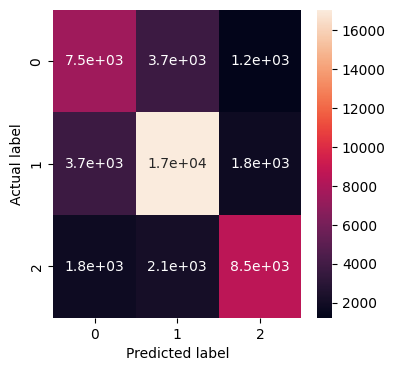

In [ ]:
plt.figure(figsize=(4,4))

cm = confusion_matrix(y_true=y_test, y_pred=pred,
                  labels=model_clf.classes_)
sns.heatmap(cm, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
score = roc_auc_score(y_true=y_test, y_score=pred_proba,
              average='macro', multi_class = 'ovr')
print(score)

0.87787054000637


## What Else?

Как можно было бы поступить ещё?

1. **Токенизация.** Можно было бы спуститься на уровень ниже и самостоятельно от текстов перейти к его токенам. Такое самостоятельное разбиение можно сделать, например, так:
  * Попробовать разбить текст по пробелу на слова и принять за токен получившееся слово. Но тут мы существенно расширяем объём словаря, с которым работаем, от этого можем как излишне учесть малозначительные и редкие токены, так и наоборот размазать по всему словарю важность значимых слов.
  * Воспользоваться имеющимися алгоритмами токенизации: тут лидер BPE (уместно вспомнить и про BBPE). Тут же мы сами вольны задавать размер получившегося словаря и играться с этим гиперпараметром, подбирая на валидации его оптимальное значение.
2. **Эмбеддинги.** Воспользоваться иными методами получения эмбеддингов:
  * Можно в качестве бейзлайна взять Word2Vec.
  * Например, построить собственную архитектуру Encoder-Decoder модели на RNN и поиграться с кол-вом блоком. А затем взять промежуточное представление в качестве эмбединга. Но, скорее всего, из-за "плохой памяти" рекурентных сеток, такое решение вряд ли бы выиграло.
  * Воспользоваться VAE
  * Воспользоваться готовой архитекторуой трансформера, оставив лишь Encoder-часть, конечно же. Причём можно попробовать как дообучить последние слои модели на наших текстах, так и сразу брать готовое решение.
  * Поэксперементировать с другими BERT-like моделями.
  * Поиграться с методами снижения получившейся размерности пространства эмбеддингов.
3. **Классификатор**. Тут можно перепробовать как кучу разным классических алгоритмов, так и кучу разных их гиперпараметров.
  * Воспользоваться классическим SVM.
  * Воспользоваться K-means, TSNE и другими алгоритмами кластеризации.
  * Прикинуть качество логрега.
  * Поэкспериметировать с другими реализациями бустинга (XGBoost LightGBM, ...)
  * Рассмотреть другие оптимизаторы гиперпараметров (HyperOpt, Bayessian, ...)
  * Рассмотреть иные способы отбора признаков (Boruta, Stepwise алгоритм, permutation importance, ...)
  * Ну и конечно же поиграться с долями выборок для трейная, валидации и теста.
